# Practices

Instructions for the practices: 
- Read the seminar instructions and explanations. Exercises will require you to complete code, change parameters and/or comment the results.
- REMEMBER TO ADD ALL REFERENCES AND CORRECTLY QUOTE ANY RESOURCE YOU USE. VERBATIM QUOTING MUST HAVE QUOTATION MARKS ("").
- Any attempt of cheating (copying from others, copying from internet, etc.) will result in a 0 grade for the whole course and disciplinary action.
- At the end, upload the report in the "Campus global". There are separated deliverables for the report and the python code.
- Be brief in the report. Most questions are answered in a single sentence.

Hints for the code:
- Most of the parts that you need to complete are just a few lines.
- When you need to test many parameters, you can copy paste a cell several times, or use a for loop, so you don't lose previous progress.
- Look at the example notebooks! They are a python version of the same notebooks available for the Matlab version, and contain most of the code that you need to complete the exercises. Note: copy-pasting code from the examples will NOT be considered plagiarism, <strong>as long as there is a comment specifying the exact source (file and cell number)</strong>.

# Practice 2

In this practice, we will go a step further, and explore ultrasound probes with several piezoelectric elements. With this, we will be able to localise scatterers not only in the longitudinal direction, but also in the transverse direction; and emit more complex waves that specifically target sections of the space. The objective of the session are as follows;
 1) explore the emitted and received signal in a more complex setting, involving several scatterers
 2) work with a (linear) probe that contains multiple piezoelectrical elements, and understand how to use the activation delays during emission to insonate different regions of the space. Understand the effect of changing the size of the probe, and the number of elements.
 3) visualise the radiofrequency received at each individual element of the probe, and see how this information can be used to locate the axial position of the scatterers. 


With several piezoelectraical elements, we can emit more complex waves, that selectively insonate specific regions of the space. This will allow to better localise the objects, since we can compute a priori which is the insonnated region, and any reflected echo has to come from this region. In this setting, each element of the probe will be activated and emit a wave starting at a different time. The resulting wave is the constructive and destructive interference of all the waves emitted by each element. By changing the activation delays, we can change the shape and direction of the resulting wave. For instance, if we activate all elements simultaneously, we will obtain a plane wave forward, but if we activate each element sequentially from left to right, we will obtain a wave that is steered to the right, the angle depending on the delay between elements. This is very useful, since we can use a relative small probe to scan a larger areal, and since we are only acquiring one section at a time, we know that any echo received must come from the insonified region. To quantitatively examine the insonified areas, we will introduce the pressure fields (P-fields), that quantify the amount of total pressure that a point in the space will receive. They are computed based solely in the probe parameters, activation delays and attenuation.

In [9]:
import pymust, numpy as np
import matplotlib.pyplot as plt

## Part 1: P-fields

A pressure field is a map that encodes the amount of energy that reaches every point in the space.  When insonated, each scatterer will emit a spherical wave (see Huygen's principle), based on the amount of acoustic energy that arrives. Therefore, in general, most of the received signal will come from the areas which recieved higher acoustic pressure.

The pressure field will be computed only in points forming a grid, which we need to specify. If we increase the number of points, we will have a more precise field, but we will require more computational time. Here, we will use a rectangular grid, but other choices are also possible, such as a polar grid, which is more adapted for circular waves or sector scanning, that are used in phase-array (cardiac) or convex probes. Note: do not confused the position of the scatterers with this grid. We will use the *meshgrid* function from numpy to generate the grid.

### Execise 2.1: Pressure field

1. Execute the code to generate the pressure field for a linear wave without a tilt. Place two points at regions which are at the same distance but the center of the probe, but recieve different energy.

1. Use two times simus in order to get the RF associated to each point chosen in the previous exercise. What do you observe? [Note: now the probe involves many piezoelectrical elements, and as such the RF signal will have a channel for each. Now you can use the center element (channel #31)]

1. Add attenuation of 0.5dB/cm. What do you observe in the pressure field and why?

In [ ]:
#param = pymust.getparam('C5-2V')
#param = pymust.getparam('L11-5V')
param = pymust.getparam('P4-2V')

param.attenuation = 0.5

# Define the grid in which the pressure field will be computed

# Define the grid where the pressure will be computed
x = np.linspace(-5e-2,5e-2,150, dtype = float); # in m
z = np.linspace(0,10e-2,150, dtype = float); # in m
xGrid,zGrid = np.meshgrid(x,z);
yGrid = []
txdel = pymust.txdelayPlane(param, 0)
print('Computing pfield, it is a bit slow...')
opt = pymust.utils.Options()
opt.dBThresh = -6
P, _, _ = pymust.pfield(xGrid,yGrid, zGrid,txdel, param, opt);

Computing pfield, it is a bit slow...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


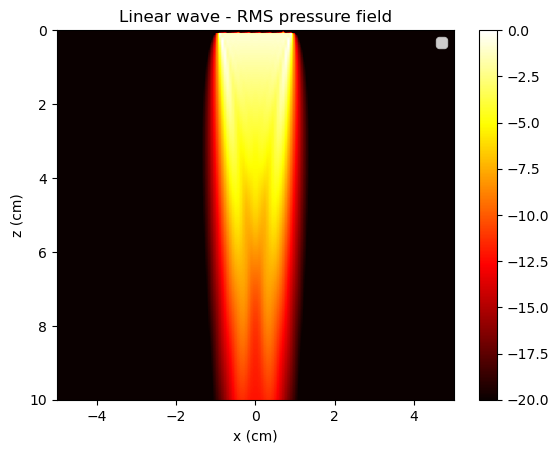

In [11]:
plt.imshow(20*np.log10(P.T/np.max(P)),
           cmap='hot',
           extent=[xGrid[0,0]*1e2,xGrid[0,-1]*1e2,zGrid[-1,0]*1e2,zGrid[0,0]*1e2],aspect='auto')
plt.colorbar()
plt.clim(-20, 0)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.title('Linear wave - RMS pressure field')

plt.legend()


Text(0.5, 1.0, 'Sampling points')

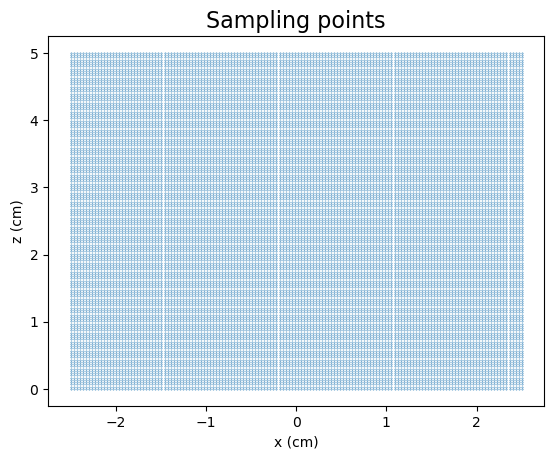

In [40]:
plt.scatter(xGrid*100, zGrid*100, s = 0.1)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.title("Sampling points", fontsize = 16)

Text(0.5, 1.0, 'Tx delays (us)')

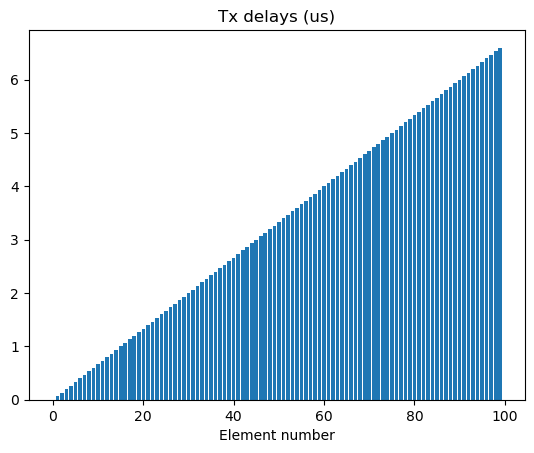

In [13]:
plt.bar(np.arange(txdel.shape[1]), txdel[0]*1e6)
plt.xlabel('Element number')
plt.title('Tx delays (us)')

## Part 2: Transmit activation delays

The pressure waves we have been generating so far have been plane waves without any tilt, thus producing a wave that propagates straight in the z direction. This is the reason why the insonated region lies directly in front of the transducer, and with the same width as the transducer. This is highly unpractical, as if we would like to scan a larger area, we would need to either use very large transducers, or move the transducer around. Moreover, this is not possible for cardiac applications, where the transducer must be positioned in the small apertures between the ribs. Here, we will show that by varying the activation delays of each piezoelectrical element, instead of activating them all at the same time, we can generate more types of waves that will allow to cover a larger area.

The waves emitted by each individual piezoelectric element can interact both constructively and destructively. By activating each element at different times, we can create waves following a different direction, and focusing at specific points. 

### Exercise 2.2: Transmit activation delays
1. Complete the multipliplot below with different types of waves. For each type of wave, try at least two different parameters, and display their pressure fields, together with the activations delays of the last parameter choice [see the multiline_transmit_demo.ipynb example to see how to plot the delays].
    1. Linear wave
    1. Focused wave
1. [EXTRA] You can generate the videos of the emitted and reflected waves, using the mkmovie function.  [Note: this can be slow]

In [ ]:
_, ((f1, f2, fX), (f3,f4, fY)) = plt.subplots(2,3, figsize = (12,6)) 

plt.sca(f1)
plt.title('Pressure field of a linear wave - XX degrees')

plt.sca(f2)
plt.title('Pressure field of a linear wave - YY degrees')

plt.sca(fX)
plt.title('Txdelays associated to the linear wave with UY degrees')

plt.sca(f3)
plt.title('Pressure field of a focused at point (x,y)')

plt.sca(f4)
plt.title('Pressure field of a focused  at point (x,y)')

plt.sca(fY)
plt.title('Txdelays associated to the linear wave - (x,y)')

plt.tight_layout()


Now we will observe how the different probe sizes, and number of elements, influence the shape of the pressure field on a linear prove. For each case, apply the differences to the probe and generate the same plot as in exercise 2.2
### Exercise 2.3 Probe size
1. Scale the probe to a 25% of the original size. (remember to make sure that the pressure field is computed at exactly the same grid). What do you observe, for every type of wave, and why? Note: you can use the function *scaleProbeDimension* to change the size of the probe.
1. Decrease the number of elements in the probe by a factor of 4, while increasing the size of the probe by a factor of 4 to maintain the total size. Re-generate the pressure fields. What do you observe and why?
1. Reduce the number of elements to a single one, which is the setting of the previous seminar. What do you observe when you try to emit a focused wave or a linear wave? Why?

In [ ]:
def scaleProbeDimension(param, factor):
    """
    Make the probe smaller or bigger, maintaining the number of elements
    """
    param.width *= factor
    param.pitch *= factor
    param.kerf *= factor
    return param

def changeNumberOfElements(param, factor):
    """
    Scale the number of piezoelectrical elements to 1
    """
    param.Nelements *= int(factor)
    return param


param = pymust.getparam('L11-5v')

# Define the properties of the scatterer, need to define the x and z position of the scatterer (z is the depth, x is the lateral position with respect to the probe), and the reflecting coefficient RC
xScatterers = np.array([0, .0e-2])
zScatterers = np.array([1e-2, 3e-2 ])
RCScatterers = np.array([1, 1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = pymust.txdelay(param, 0) ## CHANGE HERE USING TXDELAY FUNCTION. SEE THE DIFFERENT OPTIONS YOU HAVE


param.c = 1540

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param);
ts = np.arange(RF.shape[0]) /param.fs

param_shorter_probe = pymust.getparam('L11-5v')
# Make the probe smaller by dividing the length of the pitch and kerf by 4. Do you need to modify other parameter?
param_shorter_probe.width /= 4
param_shorter_probe.pitch /= 4
param_shorter_probe.kerf /= 4

RF_shorter_probe, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param_shorter_probe);
ts_shorter_probe = np.arange(RF_shorter_probe.shape[0]) /param_shorter_probe.fs


In [ ]:
x = np.linspace(-2.5e-2,2.5e-2,150, dtype = np.float32); # in m
z = np.linspace(0,5e-2,150, dtype = np.float32); # in m
xGrid,zGrid = np.meshgrid(x,z);
yGrid = []

txdel = pymust.txdelay(0.05, 0.05, param_shorter_probe)
P, _, _ = pymust.pfield(xGrid,yGrid, zGrid,txdel, param_shorter_probe);

plt.imshow(20*np.log10(P/np.max(P)),cmap='hot',extent=[x[0]*1e2,x[-1]*1e2,z[-1]*1e2,z[0]*1e2],aspect='auto')
plt.colorbar()
plt.clim(-20, 0)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')


#plt.scatter(xf*1e2,zf*1e2,c = 'b', label = 'focus point')
plt.legend()

## 